In [1]:
import math
import numpy as np
import tensorflow as tf
import PIL
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import Sequential
from tensorflow.keras.layers import ConvLSTM2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

random_state = 42

In [2]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.0.0
Num GPUs Available:  1


In [3]:
data_path = Path("F:\Workspace\shrec19retrieval\data")
do_train = True

In [4]:
class ImageSequenceGenerator(tf.keras.preprocessing.image.Iterator):
    """ Generate image time sequences from directory
        Based on keras DirectoryIterator
        Assuming class labels are integers starting from 0
    """
    def __init__(self, 
                 directory,
                 target_size=(224, 224),
                 batch_size=32,
                 shuffle=True,
                 seed=None,
                 interpolation='nearest',
                 dtype='float32'):
        self.directory = Path(directory)
        self.target_size = tuple(target_size)
        self.dtype = dtype
        self.interpolation = interpolation
        # count number of classes
        self.classnames = [subdir.parts[-1] for subdir in self.directory.iterdir() if subdir.is_dir()]
        self.dirnames = []
        self.classes = []
        for classdir in (self.directory / subdir for subdir in self.classnames):
            for sampledir in classdir.iterdir():
                if sampledir.is_dir():
                    self.dirnames.append(sampledir)
                    self.classes.append(int(classdir.parts[-1]))
        self.samples = len(self.dirnames)
        self.classes = np.array(self.classes, dtype='int32')
        self.time_len = sum(1 for _ in self.dirnames[0].iterdir())
        
        print('Found %d sequences presumably of length %d belonging to %d classes.' %
              (self.samples, self.time_len, len(self.classnames)))
        
        super().__init__(self.samples, batch_size, shuffle, seed)
        
    def transform(self, x):
        # collapse all channels to one
        x = x[:, :, 0]
        x = np.expand_dims(x, axis=-1)
        x = x / 255
        return x
    
    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros((len(index_array), self.time_len) + self.target_size + (1, ), dtype=self.dtype)
        for i, j in enumerate(index_array):
            dirname = self.dirnames[j]
            for t, imgdir in enumerate(dirname.iterdir()):
                img = load_img(imgdir, 
                               target_size=self.target_size,
                               interpolation=self.interpolation)
                x = img_to_array(img, data_format="channels_last")
                if hasattr(img, 'close'):
                    img.close()
                batch_x[i][t] = self.transform(x)
        # create categorical labels
        batch_y = np.zeros((len(batch_x), len(self.classnames)), dtype=self.dtype)
        for i, n_observation in enumerate(index_array):
            batch_y[i][self.classes[n_observation]] = 1
        return batch_x, batch_y

In [7]:
batch_size = 32

In [8]:
train_gen = ImageSequenceGenerator(data_path / "view" / "train",
                                   batch_size=batch_size,
                                   seed=random_state)
val_gen = ImageSequenceGenerator(data_path / "view" / "val",
                                   batch_size=batch_size,
                                   seed=random_state)

Found 3068 sequences presumably of length 12 belonging to 21 classes.
Found 774 sequences presumably of length 12 belonging to 21 classes.


In [54]:
# measuring speed, ignore this cell
import time

trials = []
for i in range(10):
    t0 = time.clock()
    b = next(train_gen)
    t1 = time.clock()
    trials.append(t1 - t0)

print("Sum of time: {}".format(sum(trials) / len(trials)))
print("Min of time: {}".format(min(trials)))

F:\Anaconda3\envs\tf2.0.0\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """
F:\Anaconda3\envs\tf2.0.0\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


Sum of time: 2.525414419999288
Min of time: 2.386590399997658


In [67]:
# inspection, ignore this cell
b = next(val_gen)
img = b[0][0]
print(np.mean(img), np.std(img), np.min(img), np.max(img))
print(img)

0.33363855 0.17480081 0.0 1.0
[[[[0.2509804]
   [0.2509804]
   [0.2509804]
   ...
   [0.2509804]
   [0.2509804]
   [0.2509804]]

  [[0.2509804]
   [0.2509804]
   [0.2509804]
   ...
   [0.2509804]
   [0.2509804]
   [0.2509804]]

  [[0.2509804]
   [0.2509804]
   [0.2509804]
   ...
   [0.2509804]
   [0.2509804]
   [0.2509804]]

  ...

  [[0.2509804]
   [0.2509804]
   [0.2509804]
   ...
   [0.2509804]
   [0.2509804]
   [0.2509804]]

  [[0.2509804]
   [0.2509804]
   [0.2509804]
   ...
   [0.2509804]
   [0.2509804]
   [0.2509804]]

  [[0.2509804]
   [0.2509804]
   [0.2509804]
   ...
   [0.2509804]
   [0.2509804]
   [0.2509804]]]


 [[[0.2509804]
   [0.2509804]
   [0.2509804]
   ...
   [0.2509804]
   [0.2509804]
   [0.2509804]]

  [[0.2509804]
   [0.2509804]
   [0.2509804]
   ...
   [0.2509804]
   [0.2509804]
   [0.2509804]]

  [[0.2509804]
   [0.2509804]
   [0.2509804]
   ...
   [0.2509804]
   [0.2509804]
   [0.2509804]]

  ...

  [[0.2509804]
   [0.2509804]
   [0.2509804]
   ...
   [0.25098

In [9]:
model = Sequential()
model.add(ConvLSTM2D(16, (7, 7), (3, 3), return_sequences=True, input_shape=(12, 224, 224, 1)))
model.add(ConvLSTM2D(32, (5, 5), (3, 3), return_sequences=True))
model.add(ConvLSTM2D(64, (3, 3), (3, 3), return_sequences=False))
model.add(GlobalAveragePooling2D())
model.add(Dense(21, activation="softmax"))
model.compile(Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_3 (ConvLSTM2D)  (None, 12, 73, 73, 16)    53376     
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, 12, 23, 23, 32)    153728    
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, 7, 7, 64)          221440    
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 21)                1365      
Total params: 429,909
Trainable params: 429,909
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(train_gen, 
                    epochs=500, 
                    verbose=2, 
                    validation_data=val_gen,
                    shuffle=False,
                    initial_epoch=100,
                    steps_per_epoch=1,        #train_gen.samples // batch_size,
                    validation_steps=1        #val_gen.samples // batch_size, 
                    )

Train for 1 steps, validate for 1 steps
Epoch 101/500
1/1 - 17s - loss: 3.0427 - accuracy: 0.0312 - val_loss: 3.0409 - val_accuracy: 0.0312
Epoch 102/500
1/1 - 6s - loss: 2.9976 - accuracy: 0.1562 - val_loss: 3.0707 - val_accuracy: 0.0312
Epoch 103/500
1/1 - 6s - loss: 2.8522 - accuracy: 0.1562 - val_loss: 3.3821 - val_accuracy: 0.0312
Epoch 104/500
1/1 - 6s - loss: 2.8147 - accuracy: 0.1562 - val_loss: 3.3034 - val_accuracy: 0.0312
Epoch 105/500
1/1 - 7s - loss: 2.7427 - accuracy: 0.1562 - val_loss: 3.2222 - val_accuracy: 0.0312
Epoch 106/500
1/1 - 6s - loss: 2.7074 - accuracy: 0.1562 - val_loss: 3.2124 - val_accuracy: 0.1562
Epoch 107/500
1/1 - 7s - loss: 2.6994 - accuracy: 0.1250 - val_loss: 3.2411 - val_accuracy: 0.0312
Epoch 108/500
1/1 - 7s - loss: 2.6881 - accuracy: 0.1562 - val_loss: 3.2945 - val_accuracy: 0.0312
Epoch 109/500
1/1 - 6s - loss: 2.6741 - accuracy: 0.1562 - val_loss: 3.3634 - val_accuracy: 0.0312
Epoch 110/500
1/1 - 7s - loss: 2.6639 - accuracy: 0.1562 - val_loss:

Epoch 184/500
1/1 - 6s - loss: 2.6199 - accuracy: 0.1562 - val_loss: 4.2248 - val_accuracy: 0.0312
Epoch 185/500
1/1 - 6s - loss: 2.6198 - accuracy: 0.1562 - val_loss: 4.2301 - val_accuracy: 0.0312
Epoch 186/500
1/1 - 6s - loss: 2.6198 - accuracy: 0.1562 - val_loss: 4.2363 - val_accuracy: 0.0312
Epoch 187/500
1/1 - 6s - loss: 2.6197 - accuracy: 0.1562 - val_loss: 4.2420 - val_accuracy: 0.0312
Epoch 188/500
1/1 - 6s - loss: 2.6197 - accuracy: 0.1562 - val_loss: 4.2461 - val_accuracy: 0.0312
Epoch 189/500
1/1 - 6s - loss: 2.6196 - accuracy: 0.1562 - val_loss: 4.2487 - val_accuracy: 0.0312
Epoch 190/500
1/1 - 6s - loss: 2.6196 - accuracy: 0.1562 - val_loss: 4.2503 - val_accuracy: 0.0312
Epoch 191/500
1/1 - 6s - loss: 2.6195 - accuracy: 0.1562 - val_loss: 4.2520 - val_accuracy: 0.0312
Epoch 192/500
1/1 - 6s - loss: 2.6194 - accuracy: 0.1562 - val_loss: 4.2544 - val_accuracy: 0.0312
Epoch 193/500
1/1 - 6s - loss: 2.6193 - accuracy: 0.1562 - val_loss: 4.2578 - val_accuracy: 0.0312
Epoch 194/

Epoch 267/500
1/1 - 6s - loss: 2.0671 - accuracy: 0.3125 - val_loss: 3.8049 - val_accuracy: 0.1250
Epoch 268/500
1/1 - 7s - loss: 2.0386 - accuracy: 0.3438 - val_loss: 3.8806 - val_accuracy: 0.1562
Epoch 269/500
1/1 - 7s - loss: 2.0471 - accuracy: 0.3750 - val_loss: 3.8366 - val_accuracy: 0.1562
Epoch 270/500
1/1 - 7s - loss: 2.0197 - accuracy: 0.3438 - val_loss: 3.7938 - val_accuracy: 0.1250
Epoch 271/500
1/1 - 6s - loss: 2.0303 - accuracy: 0.3125 - val_loss: 3.7939 - val_accuracy: 0.1250
Epoch 272/500
1/1 - 7s - loss: 2.0037 - accuracy: 0.3438 - val_loss: 3.8916 - val_accuracy: 0.1875
Epoch 273/500
1/1 - 7s - loss: 2.0153 - accuracy: 0.3438 - val_loss: 3.8107 - val_accuracy: 0.1250
Epoch 274/500
1/1 - 7s - loss: 1.9778 - accuracy: 0.3438 - val_loss: 3.8098 - val_accuracy: 0.1250
Epoch 275/500
1/1 - 7s - loss: 1.9831 - accuracy: 0.3125 - val_loss: 3.8666 - val_accuracy: 0.1250
Epoch 276/500
1/1 - 7s - loss: 1.9667 - accuracy: 0.3438 - val_loss: 3.8807 - val_accuracy: 0.1562
Epoch 277/

Epoch 350/500
1/1 - 6s - loss: 1.3596 - accuracy: 0.5000 - val_loss: 3.7581 - val_accuracy: 0.2500
Epoch 351/500
1/1 - 6s - loss: 1.2226 - accuracy: 0.6562 - val_loss: 3.7914 - val_accuracy: 0.2188
Epoch 352/500
1/1 - 6s - loss: 1.2545 - accuracy: 0.5312 - val_loss: 4.0352 - val_accuracy: 0.1875
Epoch 353/500
1/1 - 6s - loss: 1.2435 - accuracy: 0.5938 - val_loss: 3.8474 - val_accuracy: 0.2500
Epoch 354/500
1/1 - 6s - loss: 1.2096 - accuracy: 0.6875 - val_loss: 3.6481 - val_accuracy: 0.3125
Epoch 355/500
1/1 - 7s - loss: 1.2240 - accuracy: 0.6562 - val_loss: 3.9305 - val_accuracy: 0.2188
Epoch 356/500
1/1 - 7s - loss: 1.1664 - accuracy: 0.6562 - val_loss: 3.9396 - val_accuracy: 0.2188
Epoch 357/500
1/1 - 6s - loss: 1.1457 - accuracy: 0.6875 - val_loss: 3.7382 - val_accuracy: 0.2500
Epoch 358/500
1/1 - 6s - loss: 1.1293 - accuracy: 0.6875 - val_loss: 3.7218 - val_accuracy: 0.3125
Epoch 359/500
1/1 - 6s - loss: 1.0821 - accuracy: 0.7500 - val_loss: 3.8950 - val_accuracy: 0.2500
Epoch 360/

Epoch 433/500
1/1 - 6s - loss: 0.4417 - accuracy: 0.8750 - val_loss: 4.1324 - val_accuracy: 0.3438
Epoch 434/500
1/1 - 6s - loss: 0.4356 - accuracy: 0.8750 - val_loss: 4.1449 - val_accuracy: 0.3438
Epoch 435/500
1/1 - 6s - loss: 0.4311 - accuracy: 0.8750 - val_loss: 4.1278 - val_accuracy: 0.3438
Epoch 436/500
1/1 - 6s - loss: 0.4266 - accuracy: 0.8750 - val_loss: 4.1169 - val_accuracy: 0.3438
Epoch 437/500
1/1 - 6s - loss: 0.4225 - accuracy: 0.8750 - val_loss: 4.1300 - val_accuracy: 0.3438
Epoch 438/500
1/1 - 6s - loss: 0.4184 - accuracy: 0.8750 - val_loss: 4.1382 - val_accuracy: 0.3438
Epoch 439/500
1/1 - 5s - loss: 0.4139 - accuracy: 0.8750 - val_loss: 4.1354 - val_accuracy: 0.3438
Epoch 440/500
1/1 - 6s - loss: 0.4097 - accuracy: 0.8750 - val_loss: 4.1420 - val_accuracy: 0.3438
Epoch 441/500
1/1 - 6s - loss: 0.4055 - accuracy: 0.8750 - val_loss: 4.1515 - val_accuracy: 0.3438
Epoch 442/500
1/1 - 6s - loss: 0.4008 - accuracy: 0.8750 - val_loss: 4.1475 - val_accuracy: 0.3438
Epoch 443/

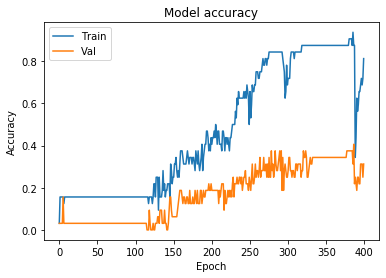

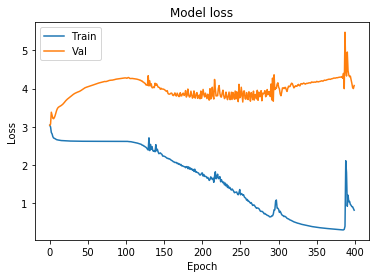

In [11]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()